# Calculate temporal statistical metrics from cloud-masked Sentinel 2 data on small areas (image chips) 

## Imports

In [1]:
from datetime import datetime
import geopandas as gpd
import io
import json
import numpy as np
import pandas as pd
from pathlib import Path
import pprint
import pystac
import pystac_client
from pystac_client import Client
import planetary_computer
import rasterio
from shapely.geometry import Point, Polygon
import rioxarray
import stackstac
from tqdm import tqdm
import xarray as xr

## Functions

In [2]:
def get_items(pystac_lient_url: str, datetimes: str, chip: pd.core.series.Series):

    stac = pystac_client.Client.open(pystac_lient_url)
    search = stac.search(
        intersects=dict(type="Point", coordinates=[chip.longitude, chip.latitude]),
        datetime=datetimes,
        collections=["sentinel-2-l2a"],
        limit=500,  # fetch items in batches of 500
        query={
            "eo:cloud_cover": {"lt": 80},
            # we only work with small chip areas and only use data from one zone
            # this avoids duplicates while we should not miss any data
            "proj:epsg": {"eq": int(chip.epsg)},
        },
    )
    candidate_items = list(search.get_items())
    ## scenes db for overview
    ids = []
    geometries = []
    cloud_cover = []
    pt = Point([chip.longitude, chip.latitude])

    for item in candidate_items:
        ids.append(item.id)
        # poly = Polygon.from_bounds(*item.bbox)
        assert len(item.geometry["coordinates"]) == 1
        poly = Polygon(item.geometry["coordinates"][0])
        geometries.append(poly)
        cloud_cover.append(item.properties["eo:cloud_cover"])

    scenes = pd.DataFrame(
        {"id": ids, "geometry": geometries, "cloud_cover": cloud_cover}
    )

    # https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/naming-convention
    candidate_scenes = pd.concat(
        [
            scenes,
            scenes.id.str.split("_", expand=True).rename(
                {
                    0: "mission",
                    1: "product_level",
                    2: "datatake_sensing_start",
                    3: "relative_orbit",
                    4: "tile",
                    5: "product_discriminator",
                },
                axis=1,
            ),
        ],
        axis=1,
    )

    candidate_scenes["date"] = pd.to_datetime(
        candidate_scenes["datatake_sensing_start"].str[:8]
    )
    candidate_scenes["chip_id"] = chip["chip_id"]

    candidate_scenes["unique_acquisitions"] = False
    keep = candidate_scenes.groupby(["mission", "date"]).first()["id"]
    candidate_scenes.loc[scenes["id"].isin(keep), "unique_acquisitions"] = True

    scenes = candidate_scenes.query("unique_acquisitions")
    items = [it for it in candidate_items if it.id in scenes["id"].values]
    assert len(items) == scenes.shape[0]
    return items, candidate_scenes


def mask_bands_with_valid_pixel_mask(stack_bands, stack_valid_pixel_mask):
    return stack_bands.where(stack_valid_pixel_mask == 1, np.nan)


def filter_times_given_periods(datetime_list, periods):
    filtered_dates = []
    for period in periods:  # example format of period: '2018-01-01/2018-03-31'
        dt_from = np.datetime64(period.split("/")[0])
        dt_to = np.datetime64(period.split("/")[1])
        filter_dates = filter(lambda d: (d >= dt_from) & (d < dt_to + 1), datetime_list)
        filtered_dates += list(filter_dates)
    return filtered_dates


def quantiles_from_masked_band_time_stack(stack_masked_band_time_series, quantiles):
    return stack_masked_band_time_series.quantile(
        q=quantiles, dim="time"
    )  # needed if we do not do .compute().chunk(None) before calling this ufunc .chunk(dict(time=-1))

## Input data and parameters

In [3]:
# # input data
# copy of a geopandas.GeoDataFrame().to_json()
geojson_chips = '{"type": "FeatureCollection", "features": [{"id": "2", "type": "Feature", "properties": {"chip_id": 2, "easting": 688503.1824475648, "epsg": 32632, "id": "Lerchenauer See", "latitude": 48.19723, "longitude": 11.53678, "maxx": 689460.0, "maxy": 5342280.0, "minx": 687600.0, "miny": 5340420.0, "northing": 5341333.603224352, "tiles": "32UPU", "zone_letter": "U", "zone_number": 32}, "geometry": {"type": "Polygon", "coordinates": [[[11.524234094137505, 48.18928587085897], [11.525055996690533, 48.20600379648934], [11.550065587909714, 48.205451427901956], [11.549235566161816, 48.18873382438354], [11.524234094137505, 48.18928587085897]]]}}, {"id": "3", "type": "Feature", "properties": {"chip_id": 3, "easting": 705439.5861520077, "epsg": 32632, "id": "Kieswerk Ebenhoeh", "latitude": 48.18998, "longitude": 11.76433, "maxx": 706380.0, "maxy": 5342040.0, "minx": 704520.0, "miny": 5340180.0, "northing": 5341111.3411528235, "tiles": "32UPU, 32UQU", "zone_letter": "U", "zone_number": 32}, "geometry": {"type": "Polygon", "coordinates": [[[11.751522831107586, 48.18190724189189], [11.752418453742267, 48.198622128828674], [11.777419839448665, 48.19802037502167], [11.77651610687036, 48.18130583892132], [11.751522831107586, 48.18190724189189]]]}}, {"id": "4", "type": "Feature", "properties": {"chip_id": 4, "easting": 706949.9406789518, "epsg": 32632, "id": "Marzlinger Weiher", "latitude": 48.392441, "longitude": 11.795693, "maxx": 707880.0, "maxy": 5364600.0, "minx": 706020.0, "miny": 5362740.0, "northing": 5363696.487794535, "tiles": "32UPU, 32UQU", "zone_letter": "U", "zone_number": 32}, "geometry": {"type": "Polygon", "coordinates": [[[11.782676865182088, 48.38415047868298], [11.783589070509988, 48.40086433526531], [11.808688737925511, 48.400253896920304], [11.807768333467632, 48.38354039650945], [11.782676865182088, 48.38415047868298]]]}}, {"id": "5", "type": "Feature", "properties": {"chip_id": 5, "easting": 704137.0853263629, "epsg": 32632, "id": "Tegernsee", "latitude": 47.7421, "longitude": 11.72314, "maxx": 705060.0, "maxy": 5292180.0, "minx": 703200.0, "miny": 5290320.0, "northing": 5291228.066208213, "tiles": "32UPU, 32UQU, 32TPT, 32TQT", "zone_letter": "T", "zone_number": 32}, "geometry": {"type": "Polygon", "coordinates": [[[11.710230094604286, 47.734234541181756], [11.711098555200053, 47.750951312207526], [11.735885627074119, 47.75036268068942], [11.735009250336178, 47.73364625232421], [11.710230094604286, 47.734234541181756]]]}}, {"id": "1", "type": "Feature", "properties": {"chip_id": 1, "easting": 321827.8428315255, "epsg": 32633, "id": "Raedlinger Weiher", "latitude": 48.67412, "longitude": 12.5797, "maxx": 322740.0, "maxy": 5394960.0, "minx": 320880.0, "miny": 5393100.0, "northing": 5394057.097320923, "tiles": "32UQU, 32UQV, 33UUP, 33UUQ", "zone_letter": "U", "zone_number": 33}, "geometry": {"type": "Polygon", "coordinates": [[[12.567250916755459, 48.66524646552912], [12.5664454366049, 48.68196415944526], [12.591692294447302, 48.68249501125058], [12.59248943795, 48.66577700713926], [12.567250916755459, 48.66524646552912]]]}}]}'
chips = gpd.read_file(io.StringIO(geojson_chips))

# # parameters
valid_scl_ids = [2, 4, 5, 6]
# must contain bands and the SCL layer
bands = ["B02", "B04", "B8A", "B09", "B10", "B11", "B12", "SCL"]
datetimes_all_seasons = "2018-01-01/2019-12-31"
# seasons with breaks, e.g.
seasons = {
    "season_1": [
        "2018-01-01/2018-03-31",
        "2018-07-01/2018-09-30",
        "2019-01-01/2019-03-31",
        "2019-07-01/2019-09-30",
    ],
    "season_2": [
        "2018-04-01/2018-06-30",
        "2018-10-01/2018-12-31",
        "2019-04-01/2019-06-30",
        "2019-10-01/2019-12-31",
    ],
}
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
add_mid50 = True
add_mid80 = True

## Cluster

https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/


In [4]:
import dask_gateway

cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.scale(5)
print(cluster.dashboard_link)

# # OR

# gateway = dask_gateway.Gateway()
# cluster_options = gateway.cluster_options()
# # ['worker_cores', 'worker_memory', 'image', 'gpu', 'environment']
# cluster_options["worker_cores"] = 4
# cluster_options["worker_memory"] = 6
# # cluster_options["gpu"] = True
# cluster = gateway.new_cluster(cluster_options)
# client = cluster.get_client()
# cluster.scale(8)
# print(cluster.dashboard_link)
# cluster_options

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.848949b0e06840838f1516e8d5e8c378/status


## Target Storage

### Azure Blob

Required for methods
* `Chip.upload_quartiles_as_netcdf_to_blob`
* `Chip.upload_scenes_csv_to_blob`

```python
import getpass
import azure.storage.blob
import io

connection_string = getpass.getpass()  # prompts for the connection string
container_client = azure.storage.blob.ContainerClient.from_connection_string(
    connection_string, container_name="test"
)

# to list and delete all files ...
blob_names = [b.name for b in container_client.list_blobs()]
# container_client.delete_blobs(*blob_names)
```

### AWS S3


Required for methods
* `Chip.upload_quartiles_as_netcdf_to_bucket`
* `Chip.upload_scenes_csv_to_bucket`

In [5]:
import boto3
import getpass
access_key = getpass.getpass()
secret_key = getpass.getpass()


# Create connection to S3
s3 = boto3.resource('s3',
    aws_access_key_id = access_key,
    aws_secret_access_key = secret_key
)

# # Get bucket object
bucket_name = 'YOUR BUCKET NAME'
basedir_chips = 'chips/s2_metrics_p'

boto_bucket = s3.Bucket(bucket_name)

# # Create a test BytesIO we want to upload
# import io
# buf = io.BytesIO()
# buf.write(b"Hello S3 world!")
# # Reset read pointer. DOT NOT FORGET THIS, else all uploaded files will be empty!
# buf.seek(0)

# # Upload the file. "MyDirectory/test.txt" is the name of the object to create
# boto_test_bucket.upload_fileobj(buf, "chips/bens-bytesio-test.txt")    


 ········
 ········


Get what is already computed.

In [7]:
def list_s3_files_using_paginator(bucket_name, prefix, access_key, secret_key):
    """
    This functions list all files in s3 using paginator.
    Paginator is useful when you have 1000s of files in S3.
    S3 list_objects_v2 can list at max 1000 files in one go.
    :return: None
    """
    s3_client = boto3.client("s3",
                             aws_access_key_id = access_key,
                             aws_secret_access_key = secret_key)
    paginator = s3_client.get_paginator('list_objects_v2')
    response_iterator = paginator.paginate(
        Bucket=bucket_name,
        Prefix=prefix,
    )
    all_files = []
    for page in response_iterator:
        files = page.get("Contents")
        for file in files:
            all_files.append(file['Key'])
    return all_files


In [9]:
existing_files_in_dir = list_s3_files_using_paginator(bucket_name, basedir_chips, access_key, secret_key)

df_computed = pd.DataFrame(existing_files_in_dir, columns=['file'])
# remove directories
df_computed = df_computed.query('~file.str.endswith("/")')
df_computed['chip_id'] = df_computed['file'].str.extract(r'.*/(.*)\.\w{2,3}')
df_computed
# get all complete (csv and nc) chips
df_computed[['chip_id', 'suffix']] = df_computed['file'].str.extract(r'.*/(.*)\.(\w{2,3})')
assert df_computed['suffix'].isin(['csv', 'nc']).all()
chip_ids_computed_bool = (df_computed['chip_id'].value_counts() == 2)
chip_ids_computed = chip_ids_computed_bool[chip_ids_computed_bool].index.values

chips_to_be_processed = chips[~chips['chip_id'].isin(chip_ids_computed)]
print(chips.shape)
print(chips_to_be_processed.shape)

(29927, 15)
(29918, 15)


## Process all chips

In [10]:
# %%timeit
class ChipPercentiles:
    def __init__(
        self,
        chip,
        bands=["B02", "B04", "B8A", "B09", "B10", "B11", "B12", "SCL"],
        seasons={
            "season_1": [
                "2018-01-01/2018-03-31",
                "2018-07-01/2018-09-30",
                "2019-01-01/2019-03-31",
                "2019-07-01/2019-09-30",
            ],
            "season_2": [
                "2018-04-01/2018-06-30",
                "2018-10-01/2018-12-31",
                "2019-04-01/2019-06-30",
                "2019-10-01/2019-12-31",
            ],
        },
        quantiles=[0.1, 0.25, 0.5, 0.75, 0.9],
        add_mid50 = True,
        add_mid80 = True,
        datetimes_all_seasons="2018-01-01/2019-12-31",
        valid_scl_ids=[2, 4, 5, 6],
    ):
        
        # used in query
        self.chip = chip
        self.bands = bands
        self.datetimes_all_seasons = datetimes_all_seasons
        
        # used for cloud masking bands based on SCL
        self.valid_scl_ids = valid_scl_ids

        # used to calculate the percentiles
        self.seasons = seasons
        self.quantiles = quantiles
        self.add_mid50 = add_mid50
        self.add_mid80 = add_mid80

        # 
        
        # from get_expected_files
        self.expected_files = None

        # from get_items
        self.items = None
        self.candidate_scenes = None

        # from crate_stack_bands_masked
        self.stack_bands_masked = None

        # from create_quartiles
        self.ds_quartiles_all_seasons = None
        

    def get_filename_single_layer_tiff(self, season_name, band, quantile):
        try:
            q_name = f"{int(quantile*100):03d}"
        except:
            q_name = quantile
        filename = f"chip-{self.chip.chip_id:05d}_s2_season-{season_name.lower()}_band-{band.lower()}_q-{q_name}.tif"
        return filename
    
    # # for storing single layer tiffs (not implemented) it might be convenient to have a method like this
    # def get_expected_filenames_single_layer_tiffs(self):
    #     expected_files = []
    #     for season_name in self.seasons.keys():
    #         for band in bands:
    #             if band == "SCL":
    #                 continue
    #             else:
    #                 for quantile in quantiles:
    #                     filename = self.get_filename_single_layer_tiff(
    #                         season_name, band, quantile
    #                     )
    #                     expected_files.append(filename)
    #     self.expected_files = expected_files
    
    def get_items(self):
        # get all deduplicated items matching the query parameters
        self.items, self.candidate_scenes = get_items(
            pystac_lient_url="https://planetarycomputer.microsoft.com/api/stac/v1",
            datetimes=self.datetimes_all_seasons,
            chip=self.chip,
        )

    def crate_stack_bands_masked(self):

        # from the items create a xarray DataArray with dims ('time', 'band', 'y', 'x')
        stack = stackstac.stack(
            planetary_computer.sign(pystac.ItemCollection(self.items)),
            assets=self.bands,
            bounds=[self.chip.minx, self.chip.miny, self.chip.maxx, self.chip.maxy],
        )
        # stack containing only the scene classification layer of all scenes
        stack_scl = stack.drop_sel(band="SCL")
        # stack with a mask where all valid pixes are Treu and invalid pixes are False
        stack_valid_pixel_mask = stack.sel(band="SCL").isin(self.valid_scl_ids)
        # stack with only the B* bands
        stack_bands = stack.drop_sel(band="SCL")
        # stack with only the B* bands masked, i.d. with nan where the pixels are invalid

        # we drop ['gsd', 'common_name'] to avoid the ValueError: Variables {'gsd', 'common_name'} are coordinates in some datasets but not others.
        self.stack_bands_masked = (
            (
                stack_bands.drop_vars(["gsd", "common_name"]) \
                .groupby("band") \
                .map(
                    mask_bands_with_valid_pixel_mask,
                    stack_valid_pixel_mask=stack_valid_pixel_mask,
                )
            )
            .compute()
            .chunk({})
        )
        
    def create_quartiles(self):

        ds_quartiles_all_seasons = []
        for season_name, season_periods in self.seasons.items():

            # time subset the stack for the given season
            # get the times in the stack that fall in any of the periods of the given season
            season_times = filter_times_given_periods(
                self.stack_bands_masked.time.values, season_periods
            )
            # print(f'Time filter for season {season_name} returned {len(season_times)} of {len(stack_bands_masked.time.values)}.')
            # subset the stack
            stack_bands_masked_season = self.stack_bands_masked[
                self.stack_bands_masked.time.isin(season_times)
            ]

            # calculate quantiles
            stack_bands_masked_season_quantiles = stack_bands_masked_season.groupby(
                "band"
            ).map(quantiles_from_masked_band_time_stack, quantiles=self.quantiles)

            # add dispersion measures
            # The IQR may also be called the midspread, middle 50%, fourth spread, or H‑spread.
            # https://en.wikipedia.org/wiki/Interquartile_range
            if self.add_mid50:
                mid50 = stack_bands_masked_season_quantiles.sel(
                    quantile=0.75
                ) - stack_bands_masked_season_quantiles.sel(quantile=0.25)
                stack_bands_masked_season_quantiles = xr.concat(
                    [
                        stack_bands_masked_season_quantiles,
                        mid50.expand_dims(quantile=["mid50"]),
                    ],
                    dim="quantile",
                )
            if self.add_mid80:
                mid80 = stack_bands_masked_season_quantiles.sel(
                    quantile=0.9
                ) - stack_bands_masked_season_quantiles.sel(quantile=0.1)
                stack_bands_masked_season_quantiles = xr.concat(
                    [
                        stack_bands_masked_season_quantiles,
                        mid80.expand_dims(quantile=["mid80"]),
                    ],
                    dim="quantile",
                )
            
            # add crs and convert to desired output data type
            stack_bands_masked_season_quantiles = (
                stack_bands_masked_season_quantiles.rio.write_crs(
                    rioxarray.crs.CRS.from_epsg(self.chip["epsg"]).to_string(),
                    inplace=False,
                )
                .astype("uint16")
                .to_dataset("band")
                .expand_dims({"time_period": [season_name]})
            )
            ds_quartiles_all_seasons.append(stack_bands_masked_season_quantiles)
        ds_quartiles_all_seasons = xr.concat(
            ds_quartiles_all_seasons, dim="time_period"
        )
        # we need to make sure that the whole 
        new_coords = [str(f'p{int(q*100):03d}') if isinstance(q, float) else f'p{q}' for q in ds_quartiles_all_seasons.coords.get('quantile').values]
        ds_quartiles_all_seasons = ds_quartiles_all_seasons.assign_coords(quantile=new_coords) \
            .rename({'quantile': 'metric'})
        self.ds_quartiles_all_seasons = ds_quartiles_all_seasons

    def load_quartiles_in_memory(self):
        # we need to load result in memory else we get the following during to_netcdf
        # ValueError: invalid engine for creating bytes with to_netcdf: 'netcdf4'. Only the default engine or engine='scipy' is supported
        self.ds_quartiles_all_seasons_in_memory = (
            self.ds_quartiles_all_seasons.compute()
        )

    def upload_quartiles_as_netcdf_to_blob(self, container_client):
        filename = self.get_expected_filename_single_netcdf_file()
        with io.BytesIO() as buffer:
            buffer.write(self.ds_quartiles_all_seasons_in_memory.to_netcdf())
            buffer.seek(0)
            blob_client = container_client.get_blob_client(filename)
            blob_client.upload_blob(buffer, overwrite=True)

    def upload_scenes_csv_to_blob(self, container_client, filename):
        # filename = self.get_expected_filename_scenes_csv_file()
        with io.BytesIO() as buffer:
            self.candidate_scenes.to_csv(buffer)
            buffer.seek(0)
            blob_client = container_client.get_blob_client(filename)
            blob_client.upload_blob(buffer, overwrite=True)

    def upload_quartiles_as_netcdf_to_bucket(self, boto_bucket, filename):
        # filename = self.get_expected_filename_single_netcdf_file()
        with io.BytesIO() as buffer:
            buffer.write(self.ds_quartiles_all_seasons_in_memory.to_netcdf())
            buffer.seek(0)
            boto_bucket.upload_fileobj(buffer, filename)

    def upload_scenes_csv_to_bucket(self, boto_bucket, filename):
        # filename = self.get_expected_filename_scenes_csv_file()
        with io.BytesIO() as buffer:
            self.candidate_scenes.to_csv(buffer)
            buffer.seek(0)
            boto_bucket.upload_fileobj(buffer, filename)
            
    def write_quartiles_as_netcdf_locally(self, filename):
        # filename = dst_dir + self.get_expected_filename_single_netcdf_file()
        self.ds_quartiles_all_seasons_in_memory.to_netcdf(filename)

    def write_scenes_csv_locally(self, filename):
        # filename = dst_dir + self.get_expected_filename_scenes_csv_file()
        self.candidate_scenes.to_csv(filename)



## Try it out

```python
chip = ChipPercentiles(
    chips_to_be_processed.iloc[0],
    bands=bands,
    seasons=seasons,
    quantiles=quantiles,
    add_mid50=True,
    add_mid80=True,
    datetimes_all_seasons=datetimes_all_seasons,
    valid_scl_ids=valid_scl_ids,
)

chip.get_items()
chip.crate_stack_bands_masked()
chip.create_quartiles()
chip.load_quartiles_in_memory()

# save
chip_id = chip.chip.chip_id

# # store locally
# basedir_chips = '.'

# # aws s3

# str(Path(...) ...) is safer
# if we mess up the separaters (zero or two / instead of one) 
# aws will take it serious and create kindo of a nameless directory 
filename_nc = str(Path(basedir_chips) / f"{chip_id}.nc")
filename_s2_scenes = str((Path(basedir_chips) / f"{chip_id}.csv"))
print(filename_nc)
print(filename_s2_scenes)

chip.upload_quartiles_as_netcdf_to_bucket(boto_bucket=boto_bucket, filename=filename_nc)
chip.upload_scenes_csv_to_bucket(boto_bucket=boto_bucket, filename=filename_s2_scenes)
```

## Run for all chips


Do we face this issue here
https://stackoverflow.com/questions/66935315/disable-xarrays-automatic-use-of-dask-within-a-dask-task

### Run in a sequential loop and parallelize the computation of the single chip 

In [ ]:
# overwrite = True
# blob_names = [b.name for b in container_client.list_blobs()]

for chip_index, chip_s in tqdm(chips.iterrows(), total=chips.shape[0]):
    chip = ChipPercentiles(
        chip_s,
        bands=bands,
        seasons=seasons,
        quantiles=quantiles,
        add_mid50=True,
        add_mid80=True,
        datetimes_all_seasons=datetimes_all_seasons,
        valid_scl_ids=valid_scl_ids,
    )

    chip.get_items()
    chip.crate_stack_bands_masked()
    chip.create_quartiles()
    chip.load_quartiles_in_memory()

    # save
    chip_id = chip.chip.chip_id

    # # store locally
    # basedir_chips = '.'
    
    # # aws s3
    
    # str(Path(...) ...) is safer
    # if we mess up the separaters (zero or two / instead of one) 
    # aws will take it serious and create kindo of a nameless directory 
    filename_nc = str(Path(basedir_chips) / 'data' / f"{chip_id}.nc")
    filename_s2_scenes = str((Path(basedir_chips) / 'meatadata_s2_scenes' / f"{chip_id}.csv"))

    chip.upload_quartiles_as_netcdf_to_bucket(boto_bucket=boto_bucket, filename=filename_nc)
    chip.upload_scenes_csv_to_bucket(boto_bucket=boto_bucket, filename=filename_s2_scenes)

# without a dask cluster and local storage:

# with a dask cluster:
# cluster.scale(4)
# 100%|██████████| 5/5 [03:59<00:00, 47.81s/it]
# cluster.scale(5)
# 100%|██████████| 5/5 [02:59<00:00, 35.93s/it]

  0%|          | 4/29927 [02:21<246:23:49, 29.64s/it]

### Run in a parallel loop and do not parallelize the computation of the single chip 

In [ ]:
%%time

import concurrent

overwrite = False
blob_names = [b.name for b in container_client.list_blobs()]


def create_quartiles(chip_s, container_client, overwrite=True, blob_names=None):
    chip = ChipPercentiles(chip_s)
    if not overwrite:
        exists = (chip.get_expected_filename_single_netcdf_file() in blob_names) and (
            chip.get_expected_filename_scenes_csv_file() in blob_names
        )
        if exists:
            return 0

    chip.get_items()
    chip.crate_stack_bands_masked()
    chip.create_quartiles()
    chip.load_quartiles_in_memory()
    chip.upload_quartiles_as_netcdf_to_blob(container_client=container_client)
    chip.upload_scenes_csv_to_blob(container_client=container_client)
    return 0


# executor = concurrent.futures.ProcessPoolExecutor(8)
futures = [
    client.map(
        create_quartiles,
        chip_s,
        container_client=container_client,
        overwrite=True,
        blob_names=blob_names,
    )
    for chip_idx, chip_s in chips.iterrows()
]
# results = client.gather(futures)
# results
client.wait_for_workers()

# dask cluster:
# cluster.scale(5)
# CPU times: user 321 ms, sys: 32.4 ms, total: 353 ms
# Wall time: 5min 13s

In [55]:
cluster.close()

# APPENDIX

The way to the code above:

## Chips (geometries)

In [25]:
# copy of a geopandas.GeoDataFrame().to_json()
geojson_chips = '{"type": "FeatureCollection", "features": [{"id": "2", "type": "Feature", "properties": {"chip_id": 2, "easting": 688503.1824475648, "epsg": 32632, "id": "Lerchenauer See", "latitude": 48.19723, "longitude": 11.53678, "maxx": 689460.0, "maxy": 5342280.0, "minx": 687600.0, "miny": 5340420.0, "northing": 5341333.603224352, "tiles": "32UPU", "zone_letter": "U", "zone_number": 32}, "geometry": {"type": "Polygon", "coordinates": [[[11.524234094137505, 48.18928587085897], [11.525055996690533, 48.20600379648934], [11.550065587909714, 48.205451427901956], [11.549235566161816, 48.18873382438354], [11.524234094137505, 48.18928587085897]]]}}, {"id": "3", "type": "Feature", "properties": {"chip_id": 3, "easting": 705439.5861520077, "epsg": 32632, "id": "Kieswerk Ebenhoeh", "latitude": 48.18998, "longitude": 11.76433, "maxx": 706380.0, "maxy": 5342040.0, "minx": 704520.0, "miny": 5340180.0, "northing": 5341111.3411528235, "tiles": "32UPU, 32UQU", "zone_letter": "U", "zone_number": 32}, "geometry": {"type": "Polygon", "coordinates": [[[11.751522831107586, 48.18190724189189], [11.752418453742267, 48.198622128828674], [11.777419839448665, 48.19802037502167], [11.77651610687036, 48.18130583892132], [11.751522831107586, 48.18190724189189]]]}}, {"id": "4", "type": "Feature", "properties": {"chip_id": 4, "easting": 706949.9406789518, "epsg": 32632, "id": "Marzlinger Weiher", "latitude": 48.392441, "longitude": 11.795693, "maxx": 707880.0, "maxy": 5364600.0, "minx": 706020.0, "miny": 5362740.0, "northing": 5363696.487794535, "tiles": "32UPU, 32UQU", "zone_letter": "U", "zone_number": 32}, "geometry": {"type": "Polygon", "coordinates": [[[11.782676865182088, 48.38415047868298], [11.783589070509988, 48.40086433526531], [11.808688737925511, 48.400253896920304], [11.807768333467632, 48.38354039650945], [11.782676865182088, 48.38415047868298]]]}}, {"id": "5", "type": "Feature", "properties": {"chip_id": 5, "easting": 704137.0853263629, "epsg": 32632, "id": "Tegernsee", "latitude": 47.7421, "longitude": 11.72314, "maxx": 705060.0, "maxy": 5292180.0, "minx": 703200.0, "miny": 5290320.0, "northing": 5291228.066208213, "tiles": "32UPU, 32UQU, 32TPT, 32TQT", "zone_letter": "T", "zone_number": 32}, "geometry": {"type": "Polygon", "coordinates": [[[11.710230094604286, 47.734234541181756], [11.711098555200053, 47.750951312207526], [11.735885627074119, 47.75036268068942], [11.735009250336178, 47.73364625232421], [11.710230094604286, 47.734234541181756]]]}}, {"id": "1", "type": "Feature", "properties": {"chip_id": 1, "easting": 321827.8428315255, "epsg": 32633, "id": "Raedlinger Weiher", "latitude": 48.67412, "longitude": 12.5797, "maxx": 322740.0, "maxy": 5394960.0, "minx": 320880.0, "miny": 5393100.0, "northing": 5394057.097320923, "tiles": "32UQU, 32UQV, 33UUP, 33UUQ", "zone_letter": "U", "zone_number": 33}, "geometry": {"type": "Polygon", "coordinates": [[[12.567250916755459, 48.66524646552912], [12.5664454366049, 48.68196415944526], [12.591692294447302, 48.68249501125058], [12.59248943795, 48.66577700713926], [12.567250916755459, 48.66524646552912]]]}}]}'
pprint.pprint(json.loads(geojson_chips))

chips = gpd.read_file(io.StringIO(geojson_chips))
chips

{'features': [{'geometry': {'coordinates': [[[11.524234094137505,
                                              48.18928587085897],
                                             [11.525055996690533,
                                              48.20600379648934],
                                             [11.550065587909714,
                                              48.205451427901956],
                                             [11.549235566161816,
                                              48.18873382438354],
                                             [11.524234094137505,
                                              48.18928587085897]]],
                            'type': 'Polygon'},
               'id': '2',
               'properties': {'chip_id': 2,
                              'easting': 688503.1824475648,
                              'epsg': 32632,
                              'id': 'Lerchenauer See',
                              'latitude': 48.19723,
       

,chip_id,easting,epsg,id,latitude,longitude,maxx,maxy,minx,miny,northing,tiles,zone_letter,zone_number,geometry
0,2,688503.182448,32632,Lerchenauer See,48.197230,11.536780,689460.0,5342280.0,687600.0,5340420.0,5.341334e+06,32UPU,U,32,"POLYGON ((11.52423 48.18929, 11.52506 48.20600..."
1,3,705439.586152,32632,Kieswerk Ebenhoeh,48.189980,11.764330,706380.0,5342040.0,704520.0,5340180.0,5.341111e+06,"32UPU, 32UQU",U,32,"POLYGON ((11.75152 48.18191, 11.75242 48.19862..."
2,4,706949.940679,32632,Marzlinger Weiher,48.392441,11.795693,707880.0,5364600.0,706020.0,5362740.0,5.363696e+06,"32UPU, 32UQU",U,32,"POLYGON ((11.78268 48.38415, 11.78359 48.40086..."
3,5,704137.085326,32632,Tegernsee,47.742100,11.723140,705060.0,5292180.0,703200.0,5290320.0,5.291228e+06,"32UPU, 32UQU, 32TPT, 32TQT",T,32,"POLYGON ((11.71023 47.73423, 11.71110 47.75095..."
4,1,321827.842832,32633,Raedlinger Weiher,48.674120,12.579700,322740.0,5394960.0,320880.0,5393100.0,5.394057e+06,"32UQU, 32UQV, 33UUP, 33UUQ",U,33,"POLYGON ((12.56725 48.66525, 12.56645 48.68196..."


### Sentinel 2 data

In [26]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
s2 = catalog.get_collection("sentinel-2-l2a")

pd.DataFrame(s2.extra_fields["summaries"]["eo:bands"])

,name,description,gsd,common_name,center_wavelength,full_width_half_max
0,AOT,aerosol optical thickness,NaN,NaN,NaN,NaN
1,B01,coastal aerosol,60.0,coastal,0.443,0.027
2,B02,visible blue,10.0,blue,0.490,0.098
3,B03,visible green,10.0,green,0.560,0.045
4,B04,visible red,10.0,red,0.665,0.038
5,B05,vegetation classification red edge,20.0,rededge,0.704,0.019
6,B06,vegetation classification red edge,20.0,rededge,0.740,0.018
7,B07,vegetation classification red edge,20.0,rededge,0.783,0.028
8,B08,near infrared,10.0,nir,0.842,0.145
9,B8A,vegetation classification red edge,20.0,rededge,0.865,0.033


## Development for one chip

In [27]:
chip = chips.query("chip_id == 3").iloc[0]
type(chip)

pandas.core.series.Series

### Get Sentinel 2 scenes

#### Search candidate scenes

In [28]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

datetimes = "2018-01-01/2019-12-31"
datetimes = "2018-04-01/2018-06-30"  # short period for development

search = stac.search(
    intersects=dict(type="Point", coordinates=[chip.longitude, chip.latitude]),
    datetime=datetimes,
    collections=["sentinel-2-l2a"],
    limit=500,  # fetch items in batches of 500
    query={
        "eo:cloud_cover": {"lt": 80},
        # we only work with small chip areas and only use data from one zone
        # this avoids duplicates while we should not miss any data
        "proj:epsg": {"eq": int(chip.epsg)},
    },
)
candidate_items = list(search.get_items())
print(len(candidate_items))

44


#### Remove duplicates

Duplicates can occure in overlapping areas.

In [29]:
from shapely.geometry import Point, Polygon

## scenes db for overview
ids = []
geometries = []
cloud_cover = []
pt = Point([chip.longitude, chip.latitude])

for item in candidate_items:
    ids.append(item.id)
    # poly = Polygon.from_bounds(*item.bbox)
    assert len(item.geometry["coordinates"]) == 1
    poly = Polygon(item.geometry["coordinates"][0])
    geometries.append(poly)
    cloud_cover.append(item.properties["eo:cloud_cover"])

scenes = pd.DataFrame({"id": ids, "geometry": geometries, "cloud_cover": cloud_cover})

# https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/naming-convention
candidate_scenes = pd.concat(
    [
        scenes,
        scenes.id.str.split("_", expand=True).rename(
            {
                0: "mission",
                1: "product_level",
                2: "datatake_sensing_start",
                3: "relative_orbit",
                4: "tile",
                5: "product_discriminator",
            },
            axis=1,
        ),
    ],
    axis=1,
)

candidate_scenes["date"] = pd.to_datetime(
    candidate_scenes["datatake_sensing_start"].str[:8]
)
candidate_scenes["chip_id"] = chip["chip_id"]

candidate_scenes["unique_acquisitions"] = False
keep = candidate_scenes.groupby(["mission", "date"]).first()["id"]
candidate_scenes.loc[scenes["id"].isin(keep), "unique_acquisitions"] = True


scenes = candidate_scenes.query("unique_acquisitions")
items = [it for it in candidate_items if it.id in scenes["id"].values]
assert len(items) == scenes.shape[0]
scenes

,id,geometry,cloud_cover,mission,product_level,datatake_sensing_start,relative_orbit,tile,product_discriminator,date,chip_id,unique_acquisitions
0,S2A_MSIL2A_20180628T101031_R022_T32UPU_2020101...,"POLYGON ((10.5976289 47.75266723, 10.63109219 ...",74.809887,S2A,MSIL2A,20180628T101031,R022,T32UPU,20201012T032109,2018-06-28,3,True
1,S2B_MSIL2A_20180623T101029_R022_T32UPU_2020101...,"POLYGON ((10.59546353 47.75270623, 10.6194372 ...",73.238951,S2B,MSIL2A,20180623T101029,R022,T32UPU,20201012T013625,2018-06-23,3,True
2,S2A_MSIL2A_20180621T102021_R065_T32UQU_2020101...,"POLYGON ((12.59351092 48.69459923, 12.54939825...",26.765513,S2A,MSIL2A,20180621T102021,R065,T32UQU,20201012T003912,2018-06-21,3,True
4,S2A_MSIL2A_20180618T101021_R022_T32UQU_2020101...,"POLYGON ((11.71881526 48.7209277, 13.20828444 ...",70.462350,S2A,MSIL2A,20180618T101021,R022,T32UQU,20201011T233054,2018-06-18,3,True
5,S2B_MSIL2A_20180616T102019_R065_T32UQU_2020101...,"POLYGON ((12.59161471 48.6946563, 12.57069449 ...",9.093094,S2B,MSIL2A,20180616T102019,R065,T32UQU,20201011T225639,2018-06-16,3,True
7,S2B_MSIL2A_20180613T101019_R022_T32UQU_2020102...,"POLYGON ((11.71881526 48.7209277, 13.20828444 ...",76.781879,S2B,MSIL2A,20180613T101019,R022,T32UQU,20201027T001036,2018-06-13,3,True
8,S2A_MSIL2A_20180611T102021_R065_T32UQU_2020102...,"POLYGON ((12.59635188 48.69451371, 12.54918845...",19.475345,S2A,MSIL2A,20180611T102021,R065,T32UQU,20201026T215211,2018-06-11,3,True
10,S2A_MSIL2A_20180608T101021_R022_T32UPU_2020102...,"POLYGON ((11.80715332 47.89550923, 11.7067029 ...",27.107302,S2A,MSIL2A,20180608T101021,R022,T32UPU,20201026T190430,2018-06-08,3,True
11,S2B_MSIL2A_20180606T102019_R065_T32UQU_2020102...,"POLYGON ((12.59606776 48.69452226, 12.53213265...",36.851507,S2B,MSIL2A,20180606T102019,R065,T32UQU,20201026T173753,2018-06-06,3,True
13,S2B_MSIL2A_20180603T101019_R022_T32UQU_2020110...,"POLYGON ((11.71881526 48.7209277, 13.20828444 ...",14.911748,S2B,MSIL2A,20180603T101019,R022,T32UQU,20201103T064033,2018-06-03,3,True


### Single scene / item

#### Select item

In [30]:
selected_item = items[7]
selected_item.assets["rendered_preview"].to_dict()

{'href': 'https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=sentinel-2-l2a&item=S2A_MSIL2A_20180608T101021_R022_T32UPU_20201026T190430&assets=visual&asset_bidx=visual%7C1%2C2%2C3&nodata=0',
 'type': 'image/png',
 'title': 'Rendered preview',
 'rel': 'preview',
 'roles': ['overview']}

#### Show preview

In [31]:
from IPython.display import Image

Image(url=selected_item.assets["rendered_preview"].href, width=500)

#### Create a xarray dataset

Subset to assets and area of interest. 

In [32]:
ds = stackstac.stack(
    planetary_computer.sign(selected_item),
    assets=["B04", "B08", "B11", "B12", "SCL"],
    bounds=[chip.minx, chip.miny, chip.maxx, chip.maxy],
)
ds

<xarray.DataArray 'stackstac-e0e81572ba04579bb9baa249ea65f6e9' (time: 1,
                                                                band: 5,
                                                                y: 186, x: 186)>
dask.array<fetch_raster_window, shape=(1, 5, 186, 186), dtype=float64, chunksize=(1, 1, 186, 186), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2018-06-08...
    id                                       (time) <U54 'S2A_MSIL2A_20180608...
  * band                                     (band) <U3 'B04' 'B08' ... 'SCL'
  * x                                        (x) float64 7.045e+05 ... 7.064e+05
  * y                                        (y) float64 5.342e+06 ... 5.34e+06
    s2:mean_solar_azimuth                    float64 150.8
    ...                                       ...
    title                                    (band) <U29 'Band 4 - Red - 10m'...
    proj:bbox                                object {600000.0, 5400000.0, 709...
    common_name                              (band) object 'red' 'nir' ... None
    center_wavelength                        (band) object 0.665 0.842 ... None
    full_width_half_max                      (band) object 0.038 0.145 ... None
    epsg                                     int64 32632
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(704520.0, 5340180.0, 706380.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 704520.00|\n| 0.00,-10.00, 5342040.00|\n| 0.0...
    resolution:  10.0

#### Plot data for AOI

##### False color composite

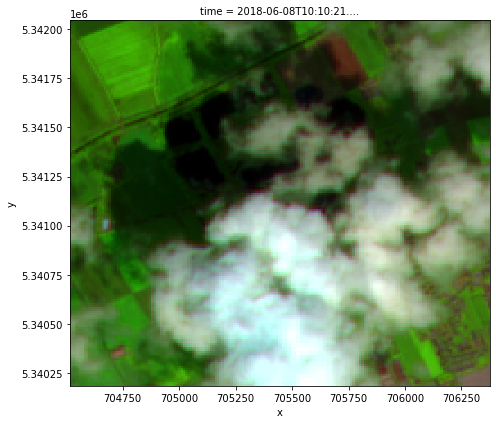

In [33]:
fcc = ds.sel(band=["B11", "B08", "B04"])
fcc.plot.imshow(row="time", rgb="band", robust=True, size=6);

##### SCL

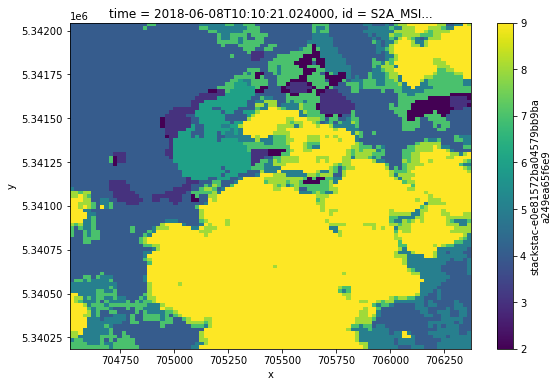

In [34]:
scl = ds.sel(band=["SCL"])
scl.plot(size=6)

#### Mask 'bad' pixels

##### Define valid pixels 

References
* https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm
* https://www.sentinel-hub.com/faq/how-get-s2a-scene-classification-sentinel-2/

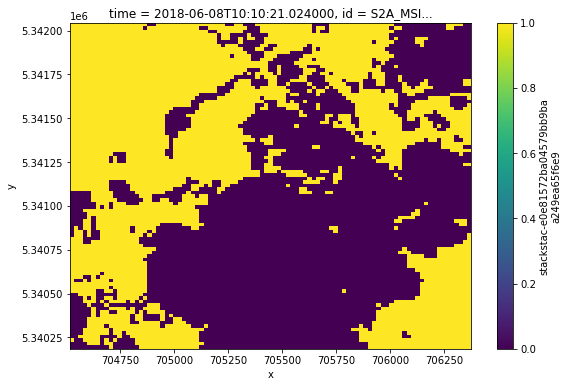

In [35]:
scl_valid_ids = [2, 4, 5, 6]

valid_mask = scl.isin(scl_valid_ids)
valid_mask.plot(size=6)

##### Mask one band

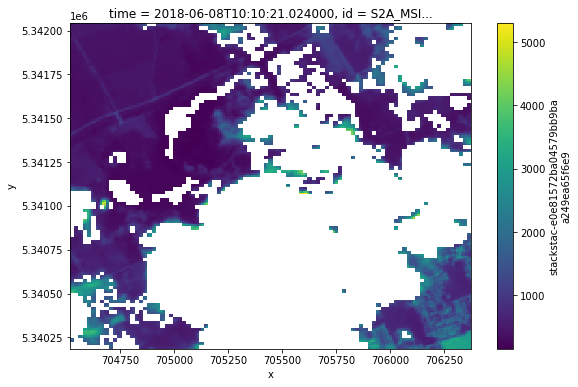

In [36]:
ds.sel(band="B04").where(valid_mask == 1, np.nan).plot(size=6)

##### Mask all bands

In [39]:
def mask_band(arr, valid_mask):
    return np.where(valid_mask == 1, arr, np.nan)


ds_bands = ds.drop_sel(band="SCL")
ds_bands_masked = xr.apply_ufunc(
    mask_band,
    ds_bands,
    kwargs={"valid_mask": valid_mask},
    dask="allowed",
    vectorize=True,
)

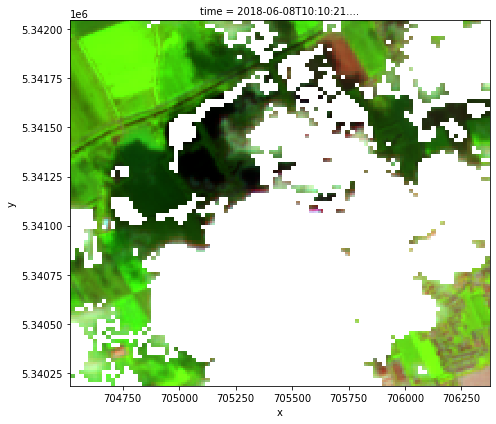

In [40]:
fcc = ds_bands_masked.sel(band=["B11", "B08", "B04"])
fcc.plot.imshow(row="time", rgb="band", robust=True, size=6);

### Refactor and apply to all scenes / items

#### Stack all items

In [42]:
ds_all = stackstac.stack(
    planetary_computer.sign(pystac.ItemCollection(items)),
    assets=["B04", "B08", "B11", "B12", "SCL"],
    bounds=[chip.minx, chip.miny, chip.maxx, chip.maxy],
)
ds_all

,Array,Chunk
Bytes,32.99 MiB,270.28 kiB
Shape,"(25, 5, 186, 186)","(1, 1, 186, 186)"
Count,375 Tasks,125 Chunks
Type,float64,numpy.ndarray


In [46]:
%%timeit
ds_all.chunk(None).compute()

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/dataset.py:2172: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  warnings.warn(


2 s ± 172 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
%%timeit
ds_all.compute()

1.09 s ± 261 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Get valid pixel arrays for all scenes

In [19]:
valid_mask_all = ds_all.sel(band="SCL").isin(scl_valid_ids)
valid_mask_all

<xarray.DataArray 'stackstac-01a97657d7744ba120ece330a99e66f8' (time: 25,
                                                                y: 186, x: 186)>
dask.array<any-aggregate, shape=(25, 186, 186), dtype=bool, chunksize=(1, 186, 186), chunktype=numpy.ndarray>
Coordinates: (12/43)
  * time                                     (time) datetime64[ns] 2018-04-02...
    id                                       (time) <U54 'S2A_MSIL2A_20180402...
    band                                     <U3 'SCL'
  * x                                        (x) float64 7.045e+05 ... 7.064e+05
  * y                                        (y) float64 5.342e+06 ... 5.34e+06
    s2:processing_baseline                   <U5 '02.12'
    ...                                       ...
    title                                    <U29 'Scene classfication map (S...
    gsd                                      float64 20.0
    common_name                              object None
    center_wavelength                        object None
    full_width_half_max                      object None
    epsg                                     int64 32632

#### Mask all scenes

In [20]:
ds_bands_all = ds_all.drop_sel(band="SCL")
ds_bands_all

,Array,Chunk
Bytes,26.39 MiB,270.28 kiB
Shape,"(25, 4, 186, 186)","(1, 1, 186, 186)"
Count,475 Tasks,100 Chunks
Type,float64,numpy.ndarray


In [21]:
def mask_all(x, valid_mask_all):
    return x.where(valid_mask_all == 1, np.nan)


ds_bands_masked_all = ds_bands_all.groupby("band").map(
    mask_all, valid_mask_all=valid_mask_all
)
ds_bands_masked_all

,Array,Chunk
Bytes,26.39 MiB,270.28 kiB
Shape,"(25, 4, 186, 186)","(1, 1, 186, 186)"
Count,1101 Tasks,100 Chunks
Type,float64,numpy.ndarray


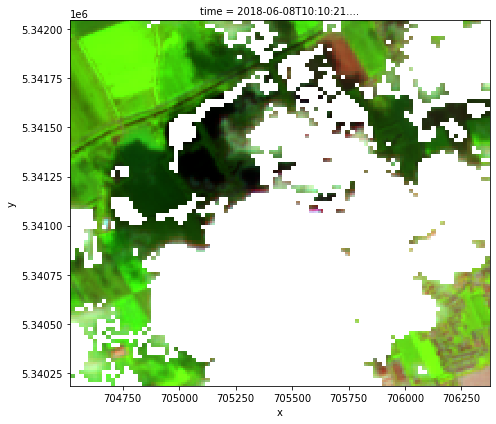

In [22]:
fcc = ds_bands_masked_all.sel(band=["B11", "B08", "B04"], time="2018-06-08")
fcc.plot.imshow(row="time", rgb="band", robust=True, size=6);

### Calculate quantiles on masked bands

In [23]:
def quantiles_from_valid_values(x, valid_mask_all):
    x_masked = x.where(valid_mask_all == 1, np.nan).chunk(dict(time=-1))
    return x_masked.quantile(
        q=[0, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 1], dim="time"
    )


ds_bands_quantiles = ds_bands_all.groupby("band").map(
    quantiles_from_valid_values, valid_mask_all=valid_mask_all
)
ds_bands_quantiles

<xarray.DataArray 'stackstac-01a97657d7744ba120ece330a99e66f8' (band: 4,
                                                                y: 186, x: 186,
                                                                quantile: 9)>
dask.array<transpose, shape=(4, 186, 186, 9), dtype=float64, chunksize=(1, 186, 186, 9), chunktype=numpy.ndarray>
Coordinates: (12/19)
  * x                                        (x) float64 7.045e+05 ... 7.064e+05
  * y                                        (y) float64 5.342e+06 ... 5.34e+06
  * quantile                                 (quantile) float64 0.0 0.05 ... 1.0
    s2:processing_baseline                   <U5 '02.12'
    instruments                              <U3 'msi'
    proj:epsg                                int64 32632
    ...                                       ...
    gsd                                      (band) float64 10.0 10.0 20.0 20.0
    common_name                              (band) object 'red' ... 'swir22'
    center_wavelength                        (band) object 0.665 0.842 1.61 2.19
    full_width_half_max                      (band) object 0.038 0.145 ... 0.242
    epsg                                     int64 32632
  * band                                     (band) <U3 'B04' 'B08' 'B11' 'B12'

In [24]:
fcc = ds_bands_quantiles.sel(
    band=["B11", "B08", "B04"], quantile=[0.1, 0.5, 0.9]
).compute()

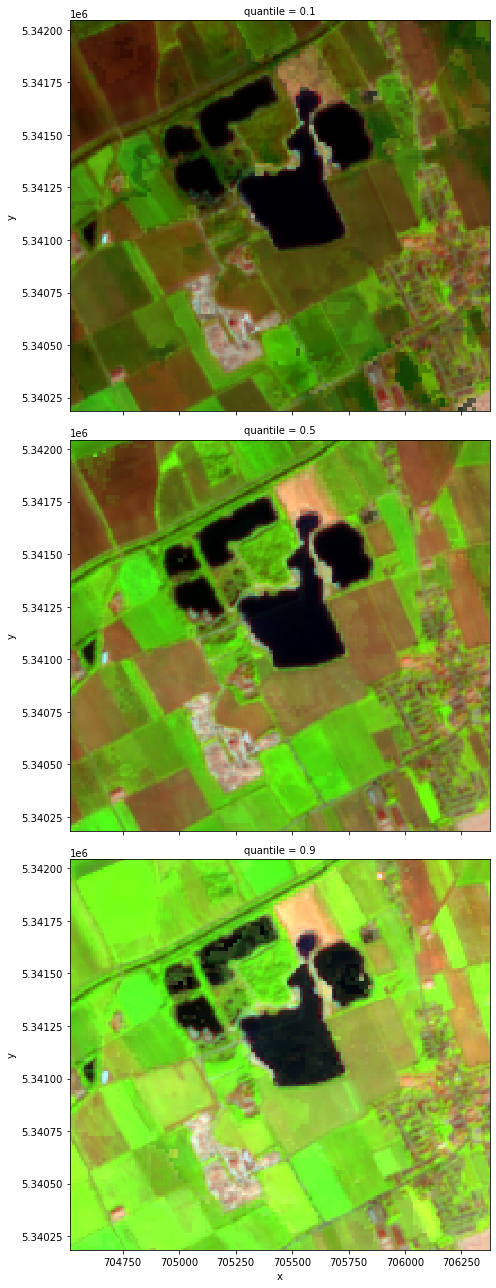

In [25]:
fcc.plot.imshow(row="quantile", rgb="band", robust=True, size=6);

### Save

In [26]:
ds_bands_quantiles_computed = ds_bands_quantiles.compute()

#### Single bands

In [29]:
import rasterio

for band in ds_bands_quantiles_computed.coords["band"].values:
    for quantile in ds_bands_quantiles_computed.coords["quantile"].values:
        arr = ds_bands_quantiles_computed.sel(band=band, quantile=quantile)
        filename = f"s2_{datetimes.replace('/', 'TO').replace('-', '')}_band-{band}_quantile-{int(quantile*100):03d}.tif"
        print(filename)
        # arr['crs'] = rasterio.crs.CRS.from_epsg('32632')
        arr.astype("uint16").rio.to_raster(
            filename, driver="COG", tiled=False, crs=rasterio.crs.CRS.from_epsg("32632")
        )
        break
    break

s2_20180401TO20180630_band-B04_quantile-000


### Write to Azure Blob Storage

In [72]:
import rasterio

rasterio.crs.CRS.from_epsg("32632")

<module 'rasterio.crs' from '/srv/conda/envs/notebook/lib/python3.8/site-packages/rasterio/crs.py'>

In [76]:
!gdalinfo s2_20180401TO20180630_band-B04_quantile-000

Driver: GTiff/GeoTIFF
Files: s2_20180401TO20180630_band-B04_quantile-000
Size is 186, 186
Origin = (704515.000000000000000,5342045.000000000000000)
Pixel Size = (10.000000000000000,-10.000000000000000)
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=BAND
  LAYOUT=COG
Corner Coordinates:
Upper Left  (  704515.000, 5342045.000) 
Lower Left  (  704515.000, 5340185.000) 
Upper Right (  706375.000, 5342045.000) 
Lower Right (  706375.000, 5340185.000) 
Center      (  705445.000, 5341115.000) 
Band 1 Block=512x512 Type=UInt16, ColorInterp=Gray
  Description = stackstac-4cac7cfdbe3613fb046e2a2543c30343


#### Stack

In [59]:
filename = f"s2_{datetimes.replace('/', 'TO').replace('-', '')}__B04_L3_features"
ds_bands_quantiles_computed.sel(band="B04").transpose(
    "quantile", "y", "x"
).rio.to_raster(filename, driver="COG", tiled=False, dtype="uint16")

## Refactor and run for multiple chips

TODO

Given that the chips are small and we want to compute percentiles for multiple time periods it might make sense to 
* load all masked data memory and
* for each period
  * select scenes
  * compute percentiles
  * save data
.